%%latex
\tableofcontents

# Introduction

This notebook describes an allele frequency analysis performed on allele frequency data compiled using the [Pharmacogenetics Analysis Workflow](https://github.com/Tuks-ICMM/Pharmacogenetic-Analysis-Pipeline).

Variant-Effect-Prediction results have been obtained from the E! Ensemble REST API for SNPs identified in our project.

> This notebook will import and make use of filtered data. The filters used are described in the first notebook of this series, which also describes the code used to perform the data.

## Objectives

## Notebook Configuration
To begin scripting, we will first need to import the set of reference files used in our analysis.

### Dependancies
This notebook describes the use of the following external dependancies and imports:

In [1]:
from upsetplot import UpSet
from pandas import read_csv
from os.path import join
from upsetplot import from_indicators
from matplotlib.figure import Figure
from matplotlib.pyplot import title, figure
from pathlib import Path

### Data Imports

The `read_csv` function from `pandas` will allow us to access data stored in serialized comma-separated-value (csv) format and import it into an in-memory copy in the form of a `DataFrame` object. This object exposes the analysis mechanisms of `pandas` and provides a toolkit for running aggregate calculations and other data-science techniques. Z-standard compression is supported by `pandas`, allowing for greater compression of report files. Next, using the `.set_index()` method provided by the `DataFrame` object, we can reindex our data using our global `MULTIINDEX` columns as the columns that should be used to create the `MultiIndex` hirachy.

> This type of hirachical indexing is the basic data-science concept behind Venn diagrams and similar data visualization techniques like UpSet plots.

Last, we rename any columns which will carry through onto any plots we make.

In [2]:
# [ASSIGN] the sample metadata used to conduct the analysis to a reference variable
SAMPLES = read_csv(join("input", "samples.csv"))

# [ASSIGN] the genomic location metadata used to conduct the analysis to a reference variable
LOCATIONS = read_csv(join("input", "locations.csv"))

# [ASSIGN] the dataset metadata used to conduct the analysis to a reference variable
DATASETS = read_csv(join("input", "datasets.csv"))

# [ASSIGN] a sorted list of all the unique population codes found in the annotations used in this analysis.
POPULATIONS_TO_COMPARE = sorted(SAMPLES["super-population"].unique().tolist())

# [ASSIGN] a sorted list of the genomic regions analyzed
LOCATIONS_COVERED = sorted(LOCATIONS["location_name"].unique().tolist())

# [ASSIGN] a list of columns to be included when constructing a multiindexx
MULTIINDEX = ["CHROM", "POS", "ID", "REF", "ALT"]


In [3]:
DATA = dict()
for gene in LOCATIONS["location_name"].unique().tolist():    
    # [ASSIGN] a DataFrame containing our imported gene-spesific datasets to our DATA object
    DATA[gene] = read_csv(
        join(
            "/",
            "mnt",
            "ICMM_HDD_12TB",
            "Results_25SEP2024",
            "cleaned",
            f"super-population_{gene}.csv.zst",
        )
    )

    # Set the VEP-based MultiIndex
    DATA[gene].set_index(MULTIINDEX, inplace=True)

    # Rename column for graphing annotations
    DATA[gene].rename(columns={"CADD_PHRED": "CADD Phred"}, inplace=True)

### Type Mapping

The E! Ensembl API returns data in serealized formats suitable for web-transfer. We will begin by first mapping the results keys to human-readable labels for the benefit of any downstream plots which may incorporate this information.

In [4]:
# For each gene
for gene in LOCATIONS["location_name"].unique().tolist():
    # Replace each entry in the "Consequence_type" column with the matching entry from this `Dict` map.
    DATA[gene]["Consequence_type"] = DATA[gene]["Consequence_type"].replace(
        {
            "3_prime_UTR_variant": "3' UTR",
            "5_prime_UTR_variant": "5' UTR",
            "TF_binding_site_variant": "TF Binding Site",
            "downstream_gene_variant": "Downstream",
            "intergenic_variant": "Intergenic",
            "intron_variant": "Intron",
            "missense_variant": "Missense",
            "non_coding_transcript_exon_variant": "Non-Coding Transcript Exon",
            "regulatory_region_variant": "Regulatory Region",
            "splice_acceptor_variant": "Splice Acceptor",
            "splice_donor_5th_base_variant": "Splice Doner 5th Base",
            "splice_donor_region_variant": "Splice Donor Region",
            "splice_polypyrimidine_tract_variant": "Splice Polypyrimidine Tract",
            "splice_region_variant": "Splice Region",
            "stop_gained": "Stop gained",
            "synonymous_variant": "Synonymous",
            "upstream_gene_variant": "Upstream",
        }
    )

In [5]:
%matplotlib inline

# `UpSet` plot
The `UpSet` object has been provided to us by the authors of the `UpSetPlot` package. This object provides the facilities to import and render an UpSet plot from correctly formatted input data.

In order to visualize the data using the `UpSet` object, the authors have requested that input be provided in the form of a `boolean` `MultiIndex` indicating partition assignment. This method of indexing is intuitive when considering aggregating complex multi-layered hirachical data, making it ideal for use with our VCF-based hierarchical `MultiIndex` (`CHROM`, `POS`, `REF` and `ALT`).

> Since the `Series`/column names on teh incomming data will be incorporated into the graph legend, they will have to be treated as reserved. Unfortionately that means there will be a name clash with the consolidated datasets produced by the workflow, so the incomming columns will have to be renamed so we can reserve the original population codes for graphing purposes.  In our case, we will assume a variable number of population groups are present that need to be analysed. As such, our analyses will be looped accordingly.

To start, we will first need to:

1. Rename each population column, as they are declared and imported from the `samples.csv` for this analysis
1. Calculate cluster assignment based on a frequency cutoff

In [6]:
# For each gene declared in my analysis
for gene in LOCATIONS["location_name"].unique().tolist():
    # For each population in my list of populations to analyse
    for population in POPULATIONS_TO_COMPARE:
        # Rename frequency columns to prevent name clash
        DATA[gene].rename(columns={f"{population}": f"{population}_freq"}, inplace=True)

        # [ASSIGN] by overwrite, a boolean column to indicate partition assignment
        DATA[gene][population] = DATA[gene][f"{population}_freq"] >= 0.02
    

Now we can make use of the `from_indicators()` function provided by `upsetplot` for setting a `MultiIndex`. See an example below:

In [7]:
from_indicators(SAMPLES["super-population"].unique().tolist(), data=DATA["CYP2B6"]).head()["query"]

AFR   EUR    EAS    AMR    SAS    CSA    OCE    UAE  
True  True   True   True   True   True   False  True     19:40991369-40991369:1/T
      False  False  True   False  False  False  False    19:40991670-40991670:1/A
                    False  False  True   False  True     19:40991696-40991696:1/A
                    True   False  False  False  False    19:40992686-40992686:1/C
                    False  False  True   False  True     19:40992772-40992772:1/A
Name: query, dtype: object

Now we are ready to begin constructing our `UpSet` graph object. This object will house all of our data and instructions for graphing, and expose methods that will action this information onto a `matplotlib` `Figure` for rendering purposes.

Lets work our way through all of our gene regions and generate `UpSet` objects for each. We can then use these later to render the graph.

In [8]:
# Store all `UpSet` objects in a `dict`
UPSETPLOT = dict()

# For each gene in the genes declared for this analysis...
for gene in LOCATIONS["location_name"].unique().tolist():
    UPSETPLOT[gene] = Figure(dpi=300)

    # Import the data to be graphed, and use the `from_indicators` function to generate
    # the needed boolean multiindex to show venn-like cluster assignment:
    plot_data = from_indicators(
        POPULATIONS_TO_COMPARE,
        data=DATA[gene].reset_index(),
    )

    # Record the initial `DataFrame` size
    _shape_before = plot_data.shape

    # Remove the partition associated with universaly shared variants (Will be all True across `MultiIndex`)
    plot_data.drop(
        [tuple(True for _i in range(0, plot_data.index.nlevels, 1))], inplace=True
    )

    # Log how many records we just removed
    print(
        f"{gene} 'universal' SNPs records dropped: {_shape_before[0] - plot_data.shape[0]} ({round(((_shape_before[0] - plot_data.shape[0])/_shape_before[0])*100)}%)"
    )

    # Generate the `UpSet` object for plotting
    TMP = UpSet(
        plot_data,
        sort_by="cardinality",
        sort_categories_by="cardinality",
        show_counts=True,
        show_percentages="{:.1%}",
        intersection_plot_elements=0,
        min_subset_size="0.2%",
    )

    # Add a stacked bar chart to the UpSet plot
    TMP.add_stacked_bars(
        by="Consequence_type",
        title="Count by \n Consequence",
        elements=10,
    )

    # UPSETPLOT[gene].add_stacked_bars(by="Impact", title="Count by \n Impact", elements=5)
    # UPSETPLOT[gene].add_catplot(value="CADD Phred", kind="violin", elements=10)

    # For each population in our list of popoulations...
    for population in POPULATIONS_TO_COMPARE:

        # Generate a copy to serve as the anti-selection list
        ANTI_LIST = POPULATIONS_TO_COMPARE.copy()

        # Remove the population selected from the anti-selection list
        ANTI_LIST.remove(population)

        # Add the styling to the population matching our selection and anti-selection criteria
        TMP.style_subsets(
            present=population,
            absent=ANTI_LIST,
            facecolor="red",
        )

    TMP.plot(UPSETPLOT[gene])
    UPSETPLOT[gene].suptitle(
        f"Variants of clinical relevance by Consequence Type \n | super-population | {gene} |",
        fontweight="bold",
        fontsize="medium",
    )

CYP2B6 'universal' SNPs records dropped: 10 (13%)
CYP2C9 'universal' SNPs records dropped: 20 (9%)
CYP2C19 'universal' SNPs records dropped: 124 (33%)


/home/students/miniconda3/envs/GRAEME_Graphing/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/students/miniconda3/envs/GRAEME_Graphing/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

CYP2D6 'universal' SNPs records dropped: 6 (16%)
CYP4F2 'universal' SNPs records dropped: 38 (34%)
VKORC1 'universal' SNPs records dropped: 1 (11%)
HLA-A 'universal' SNPs records dropped: 124 (50%)


/home/students/miniconda3/envs/GRAEME_Graphing/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/students/miniconda3/envs/GRAEME_Graphing/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

HLA-B 'universal' SNPs records dropped: 1234 (55%)


# Export
Now that we have constructed our `UpSet` objects, we can render the configured plots easily and save them to file.

In [9]:
Path(join("Graphs", "04")).mkdir(exist_ok=True)

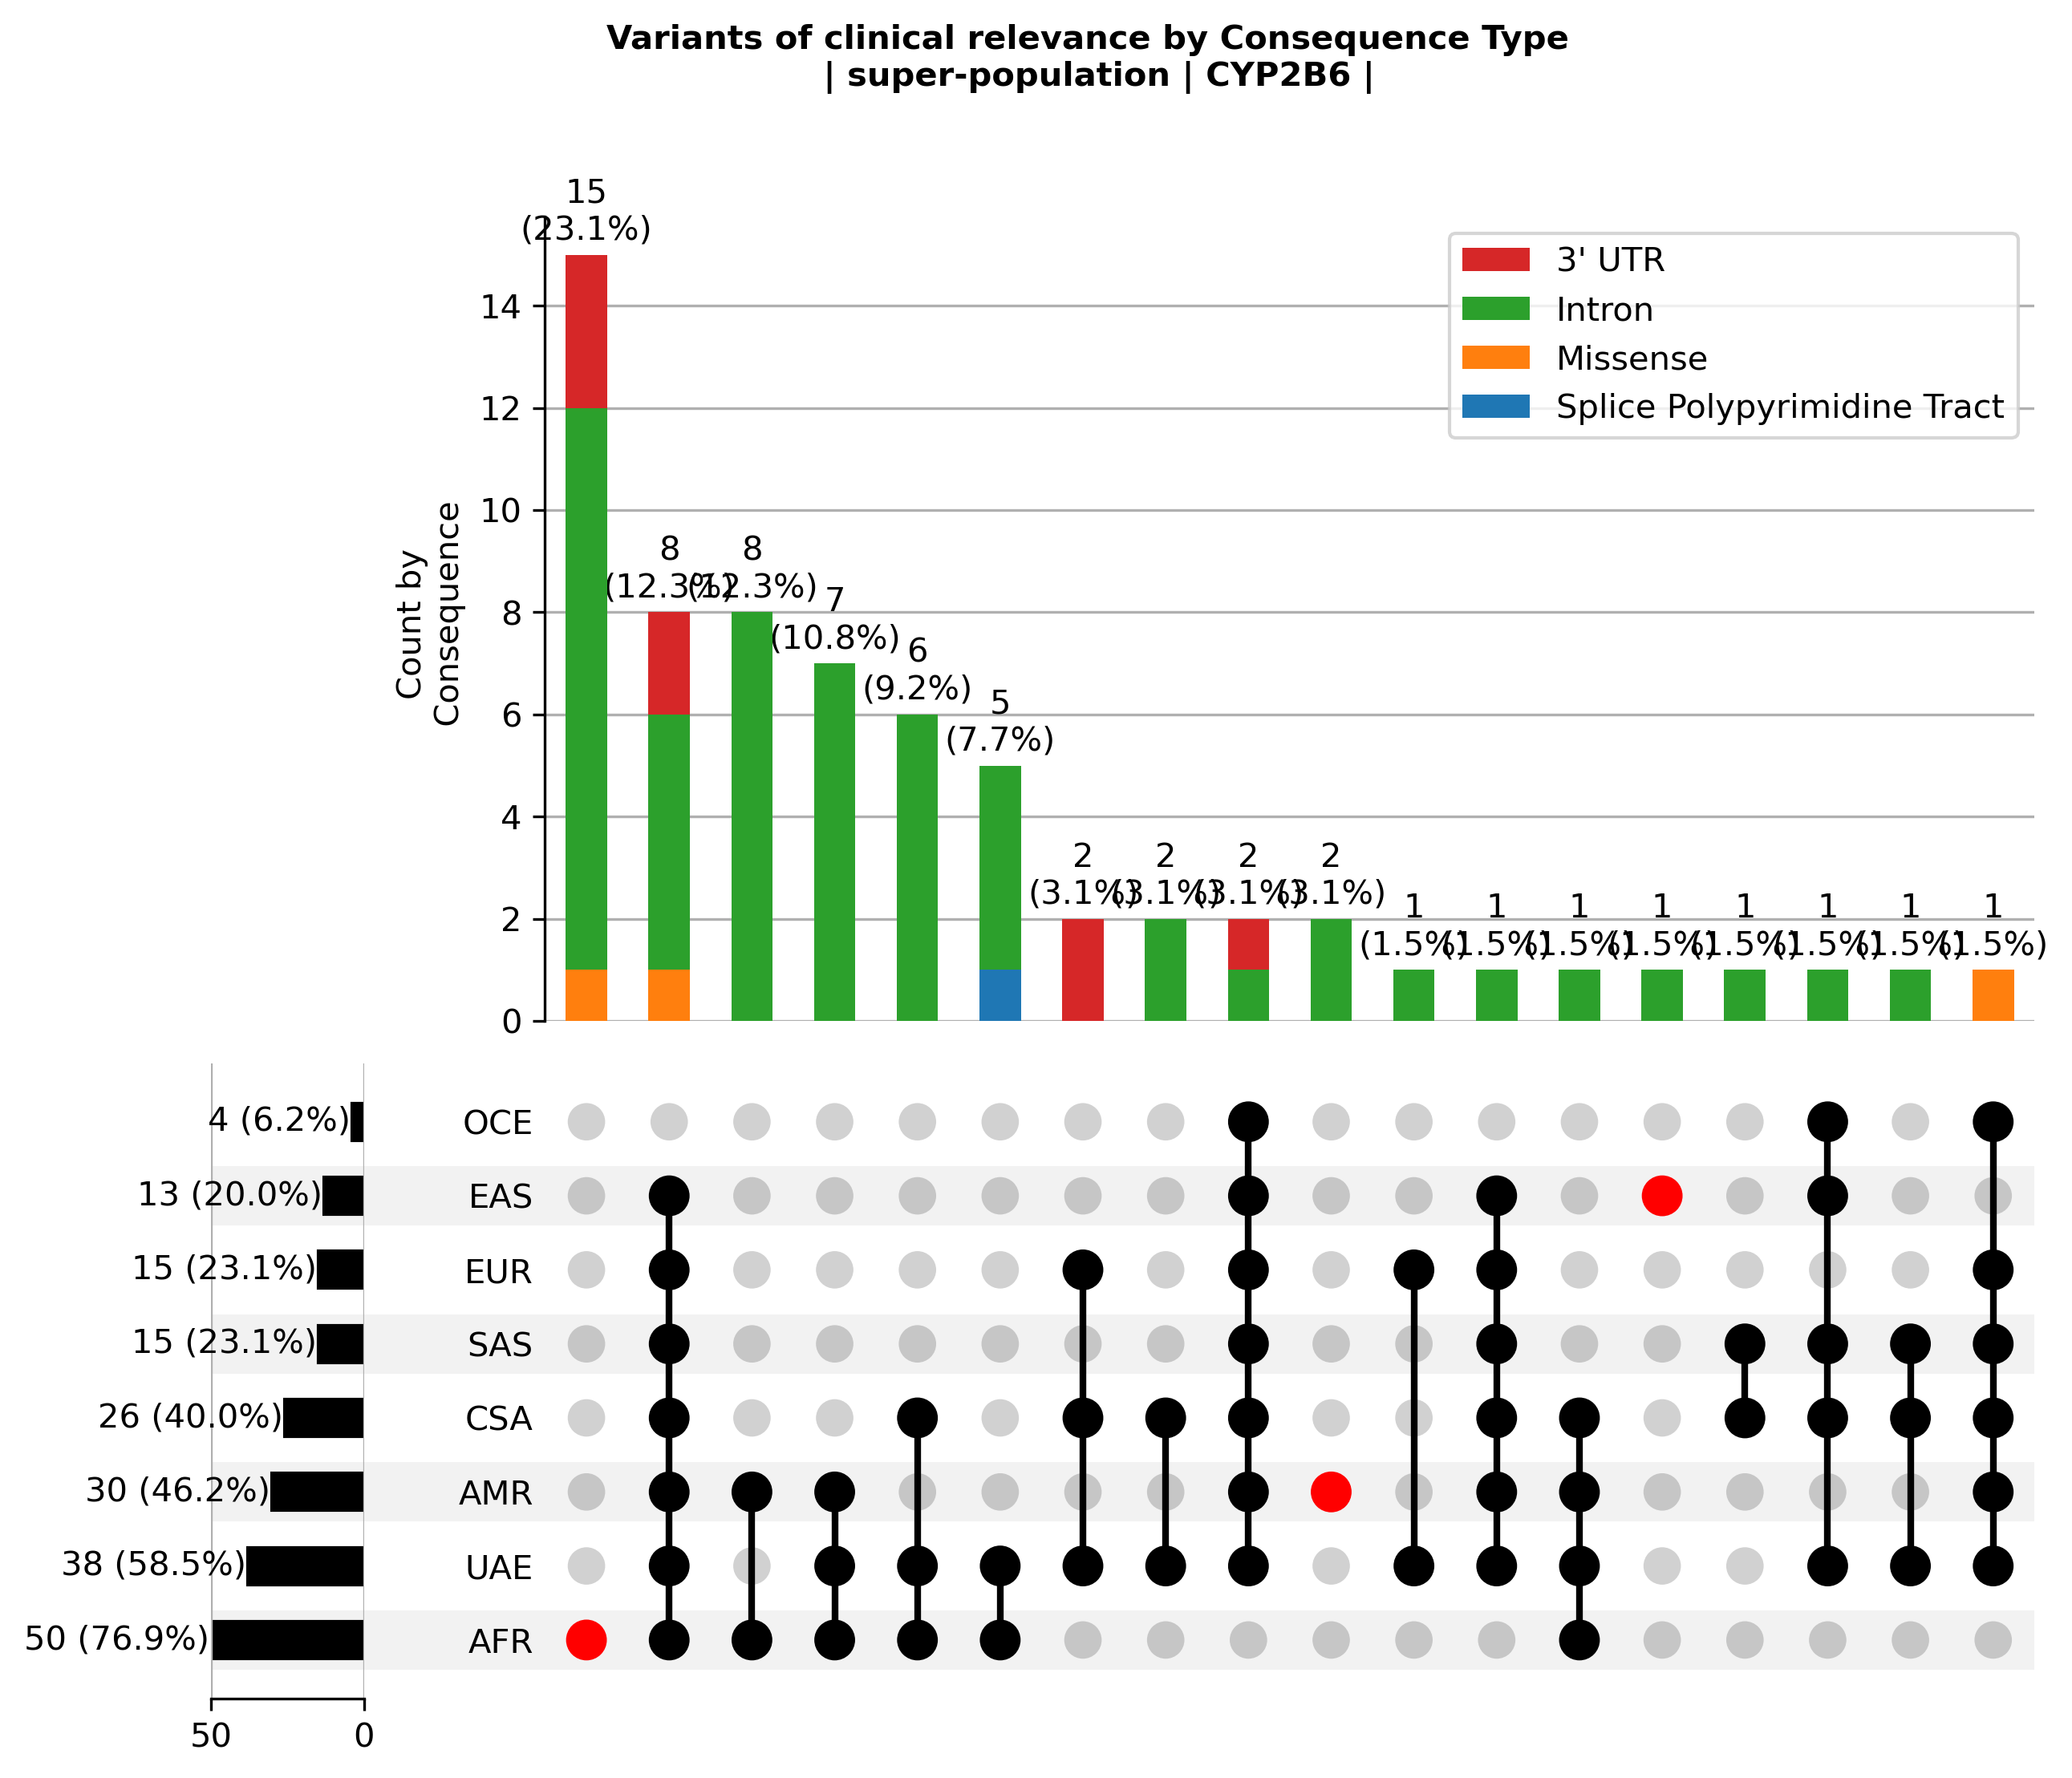

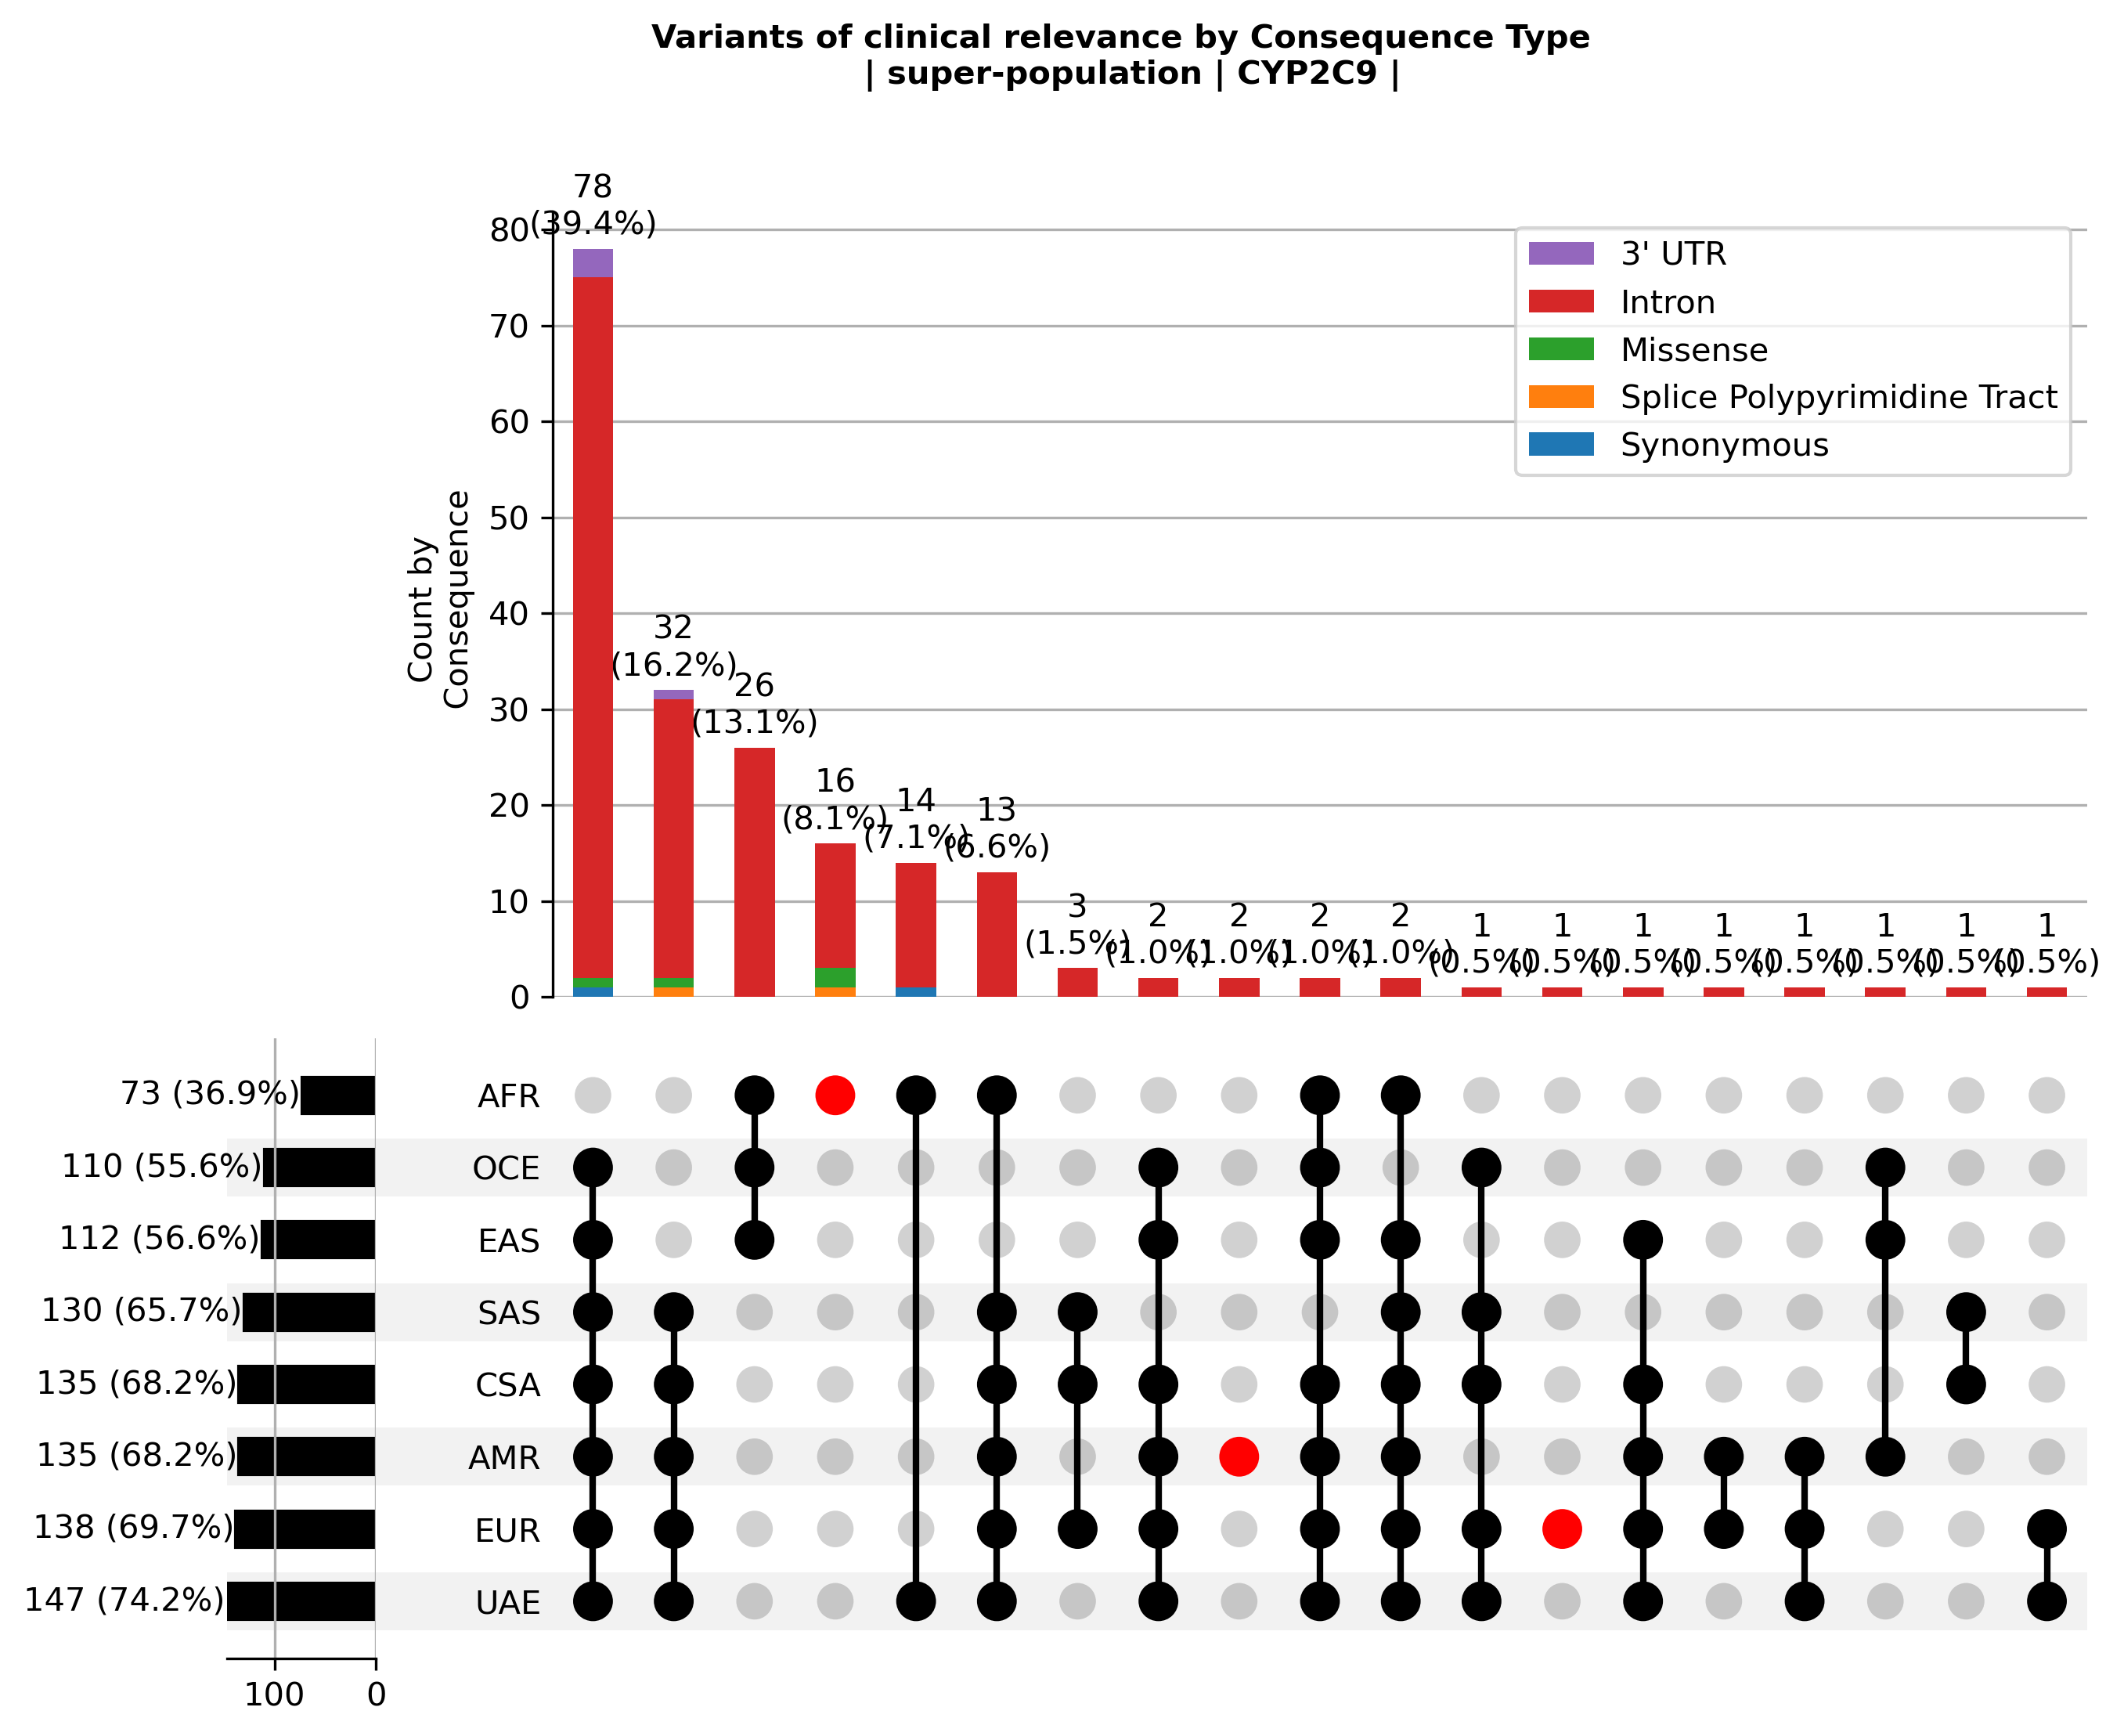

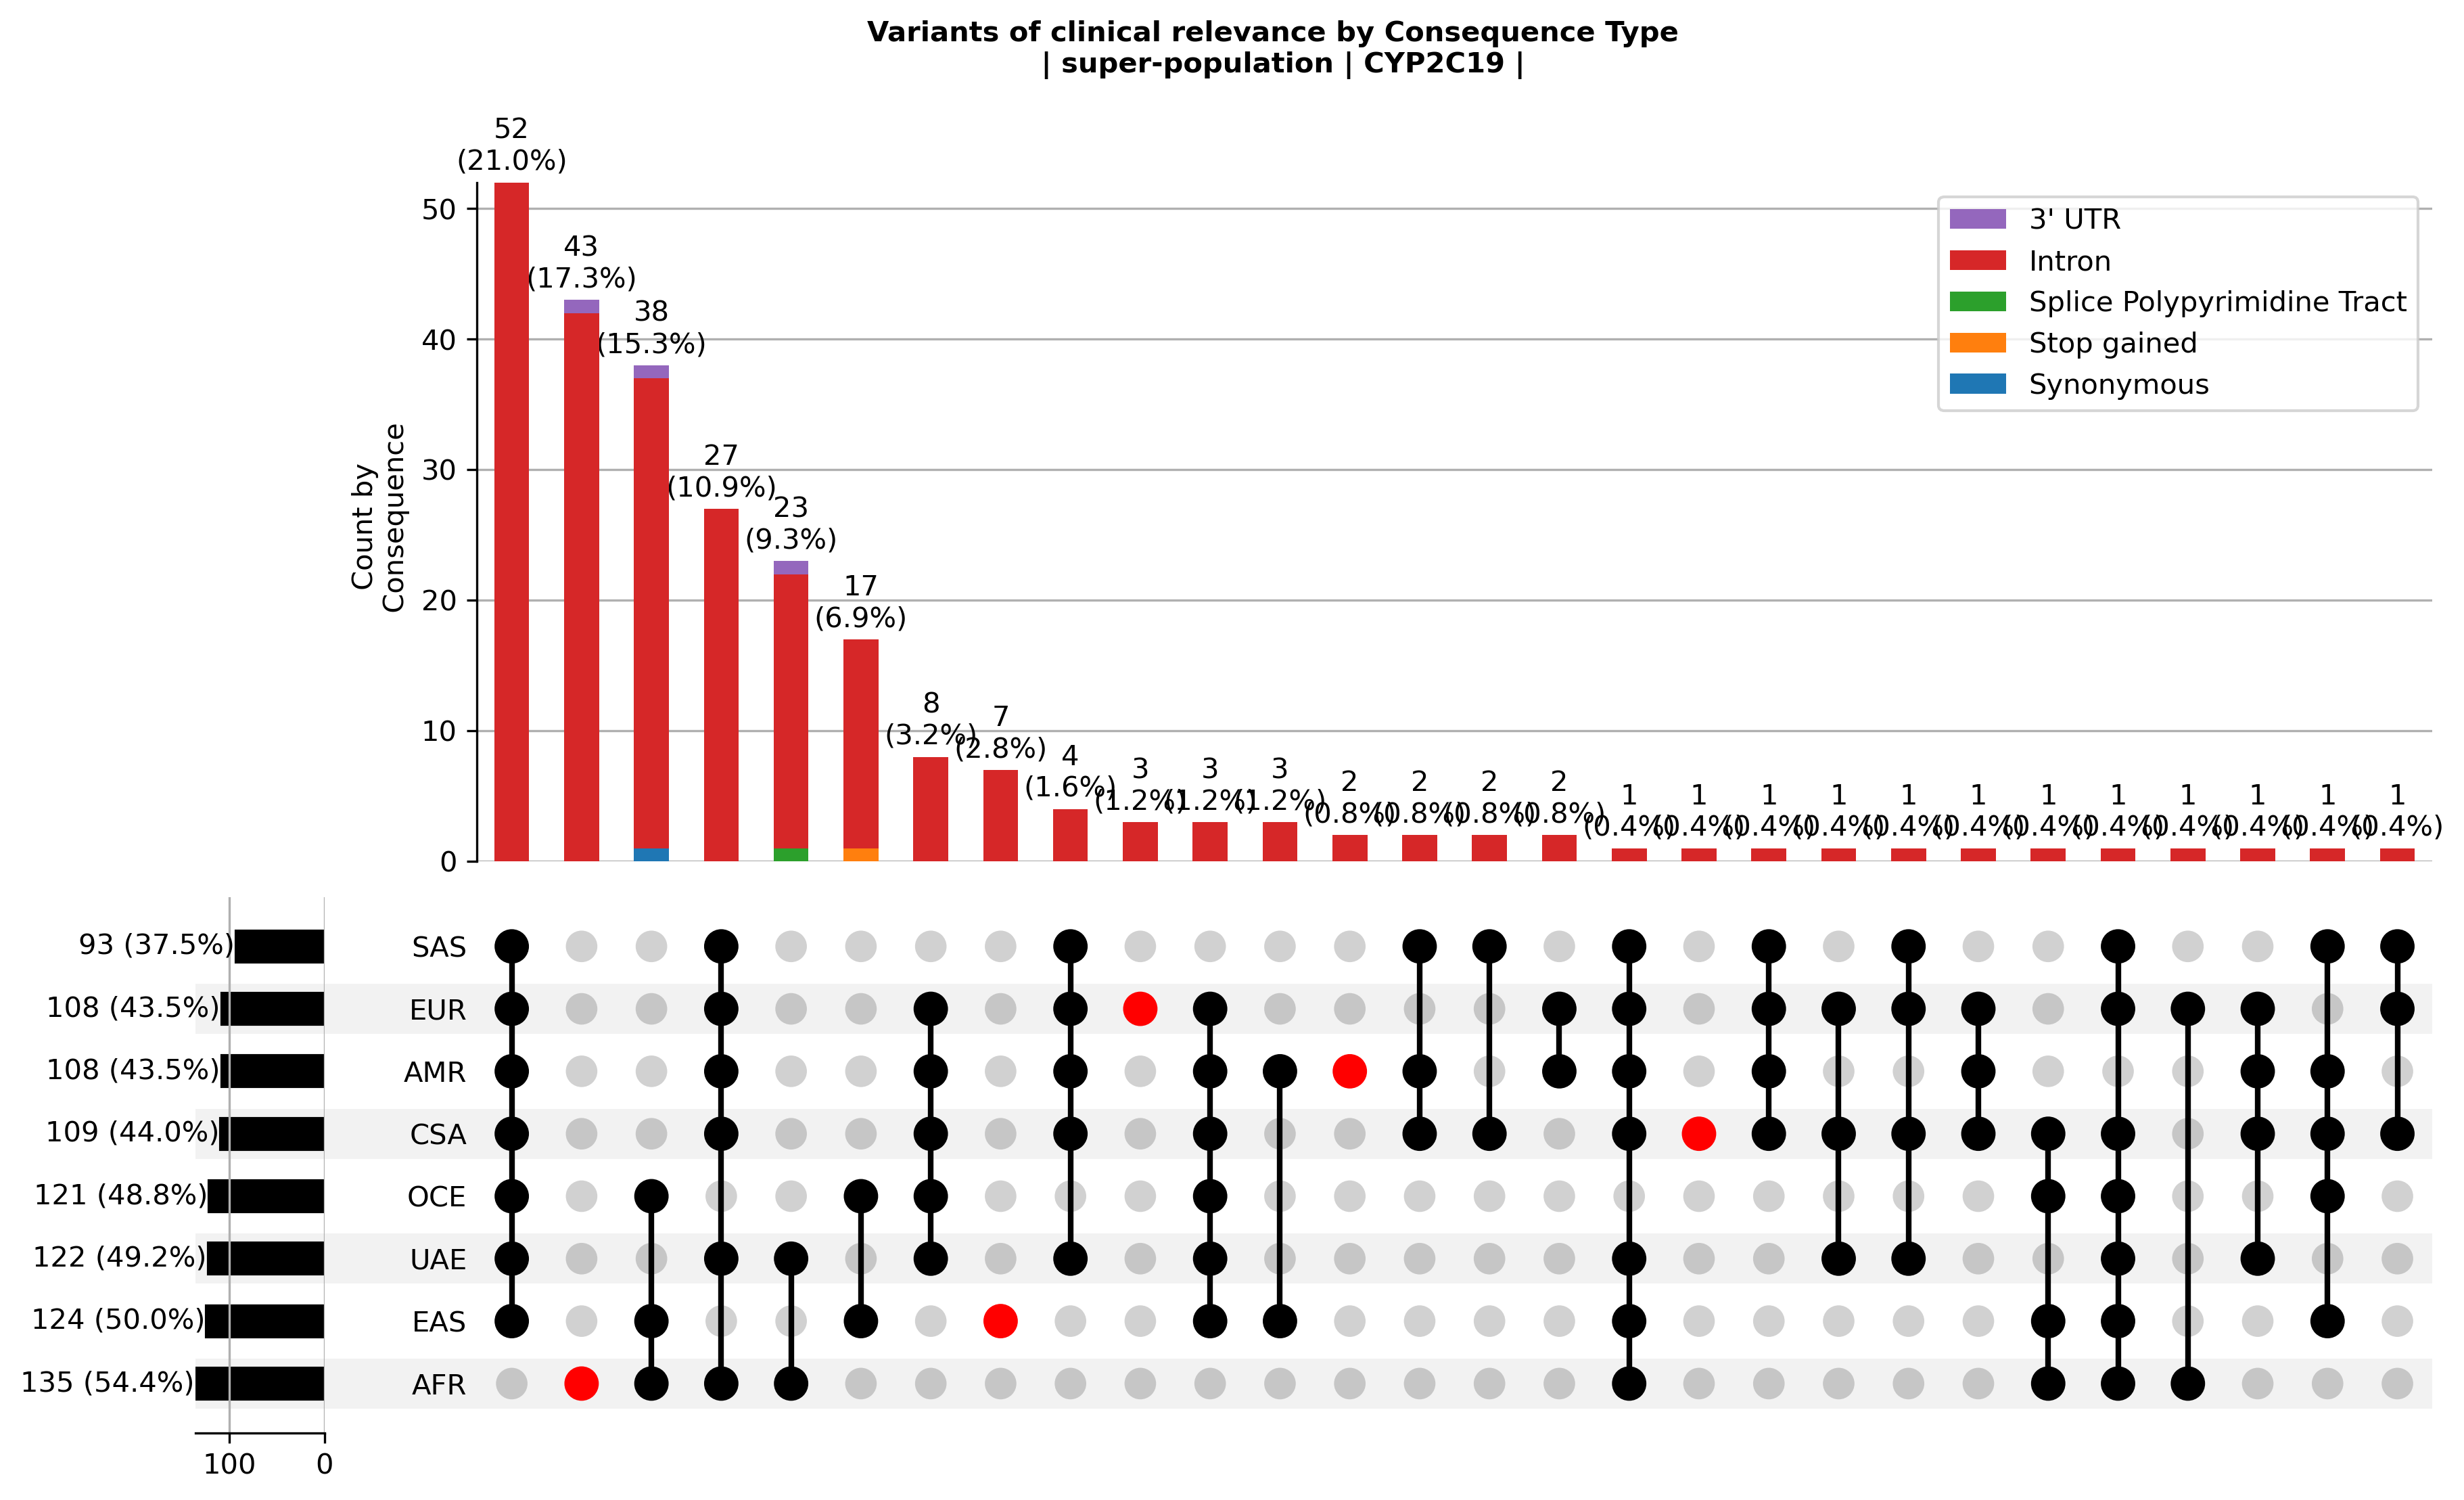

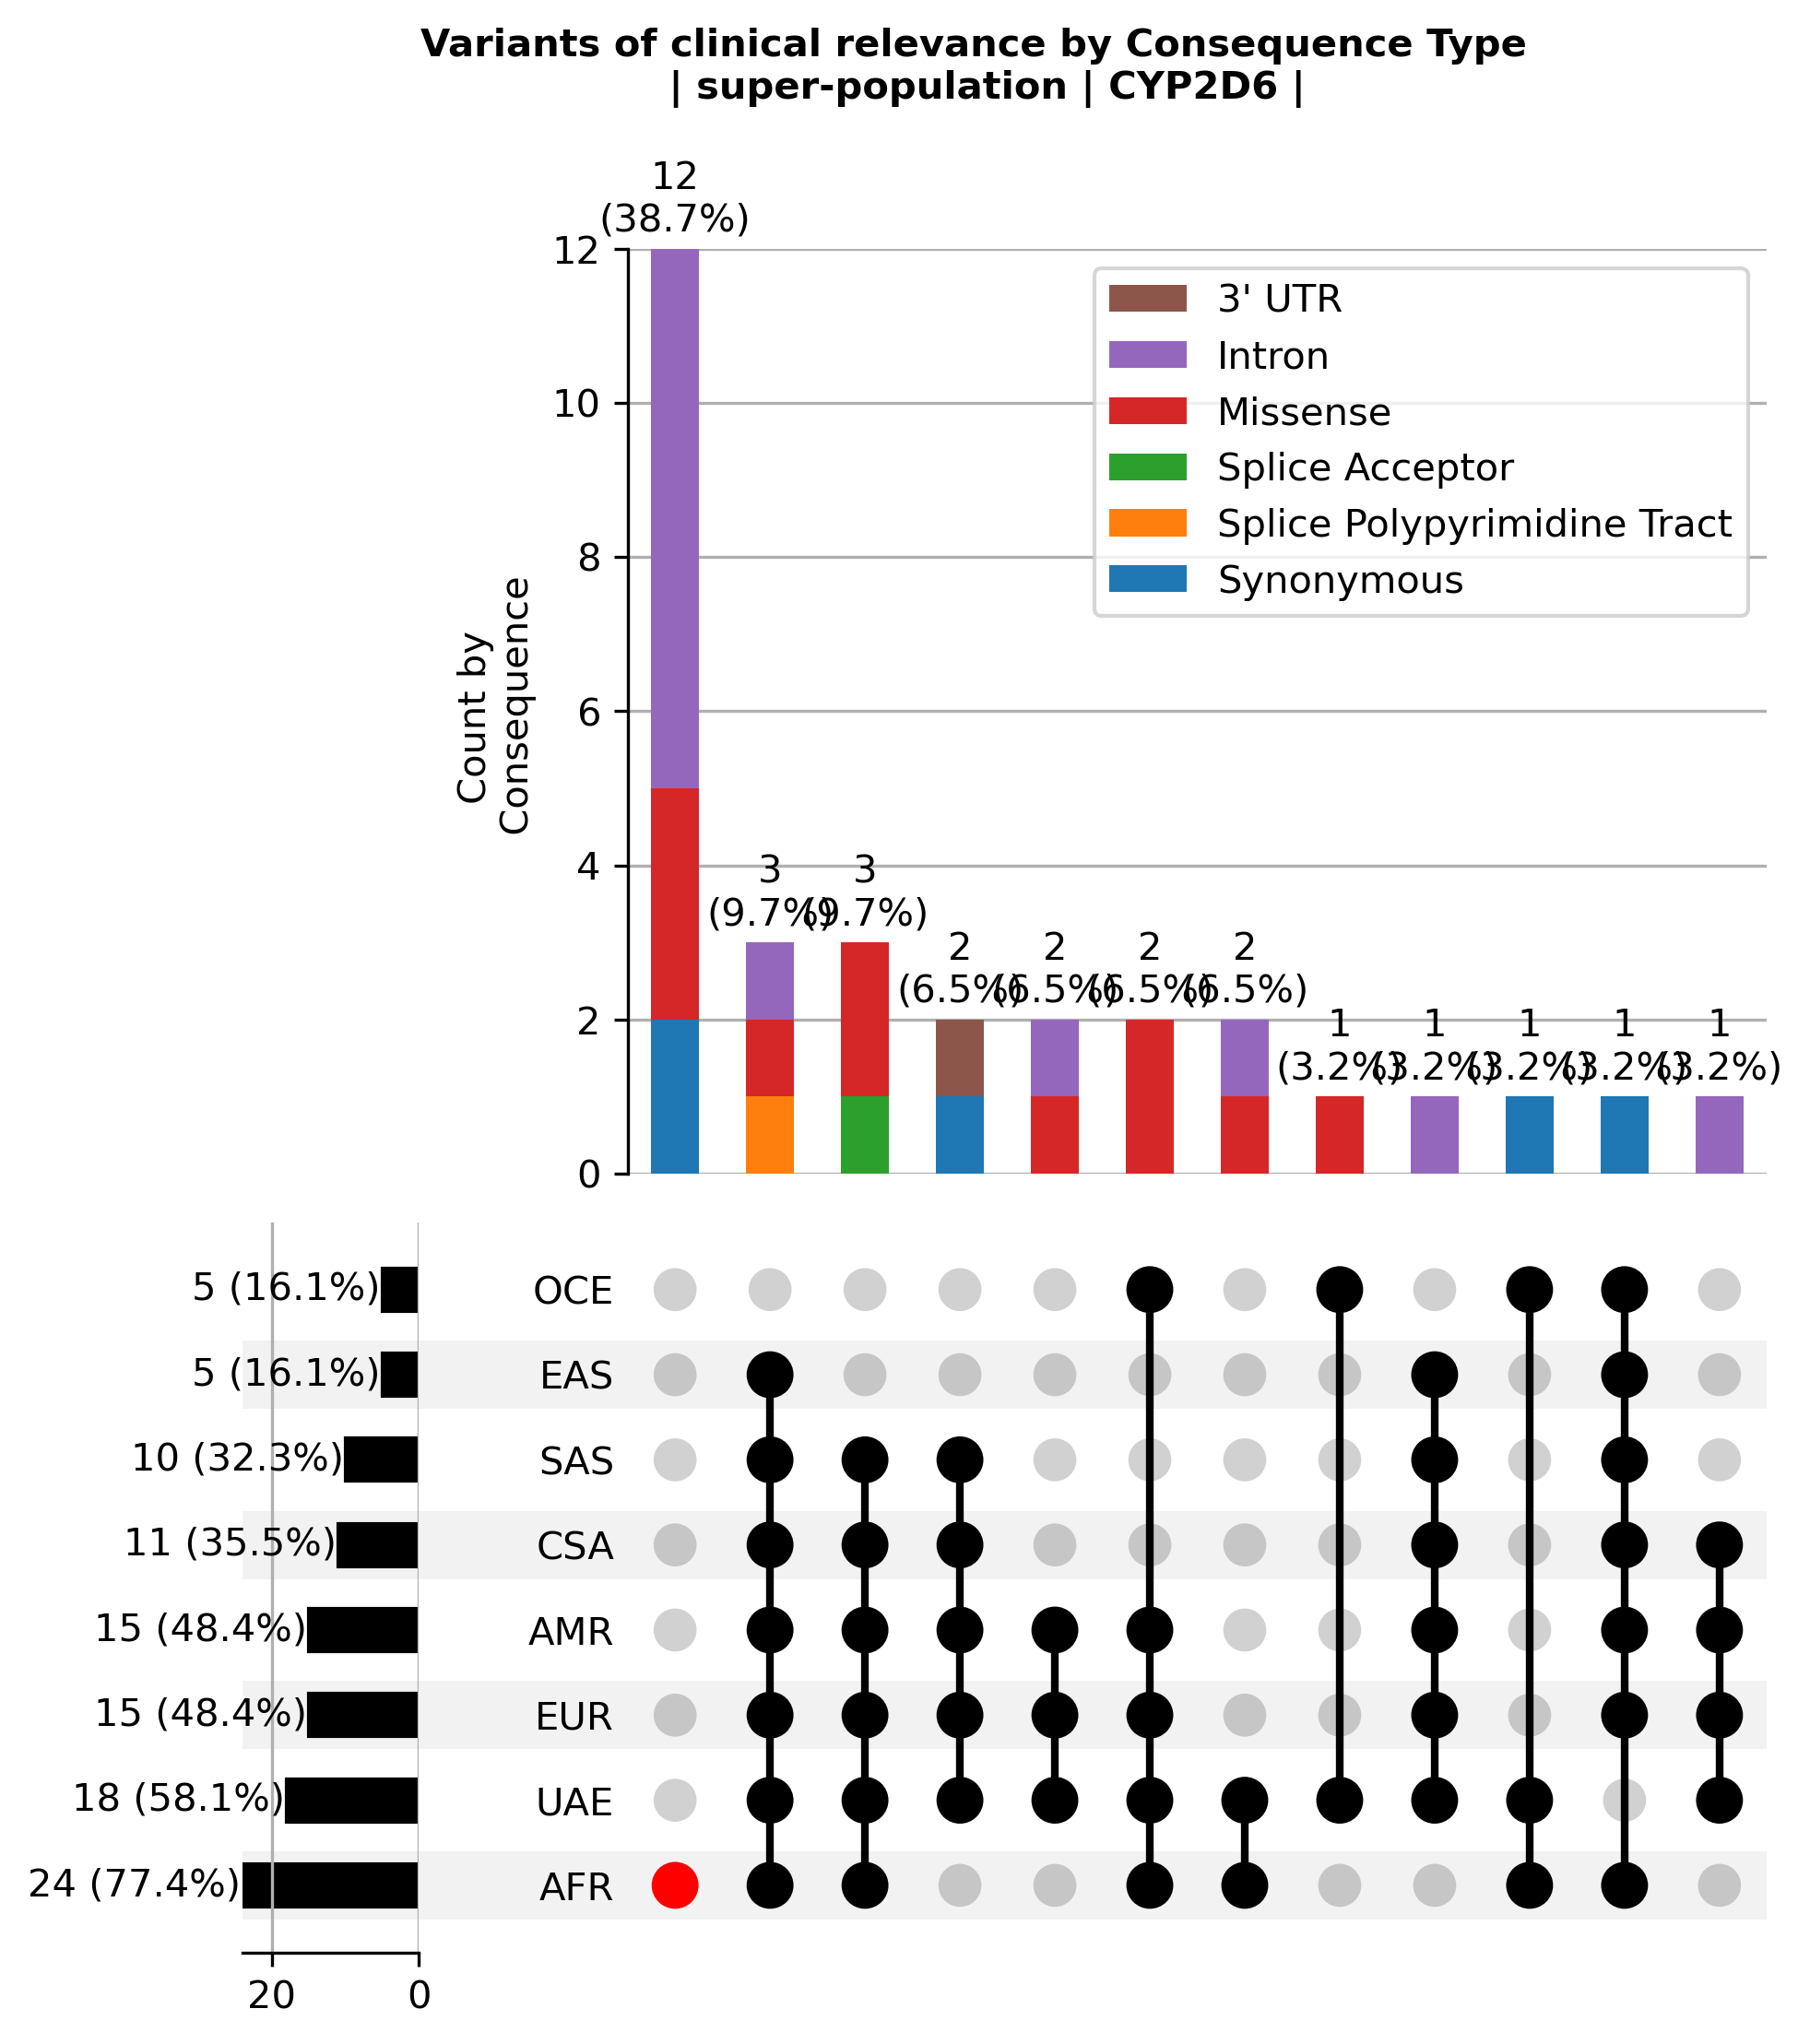

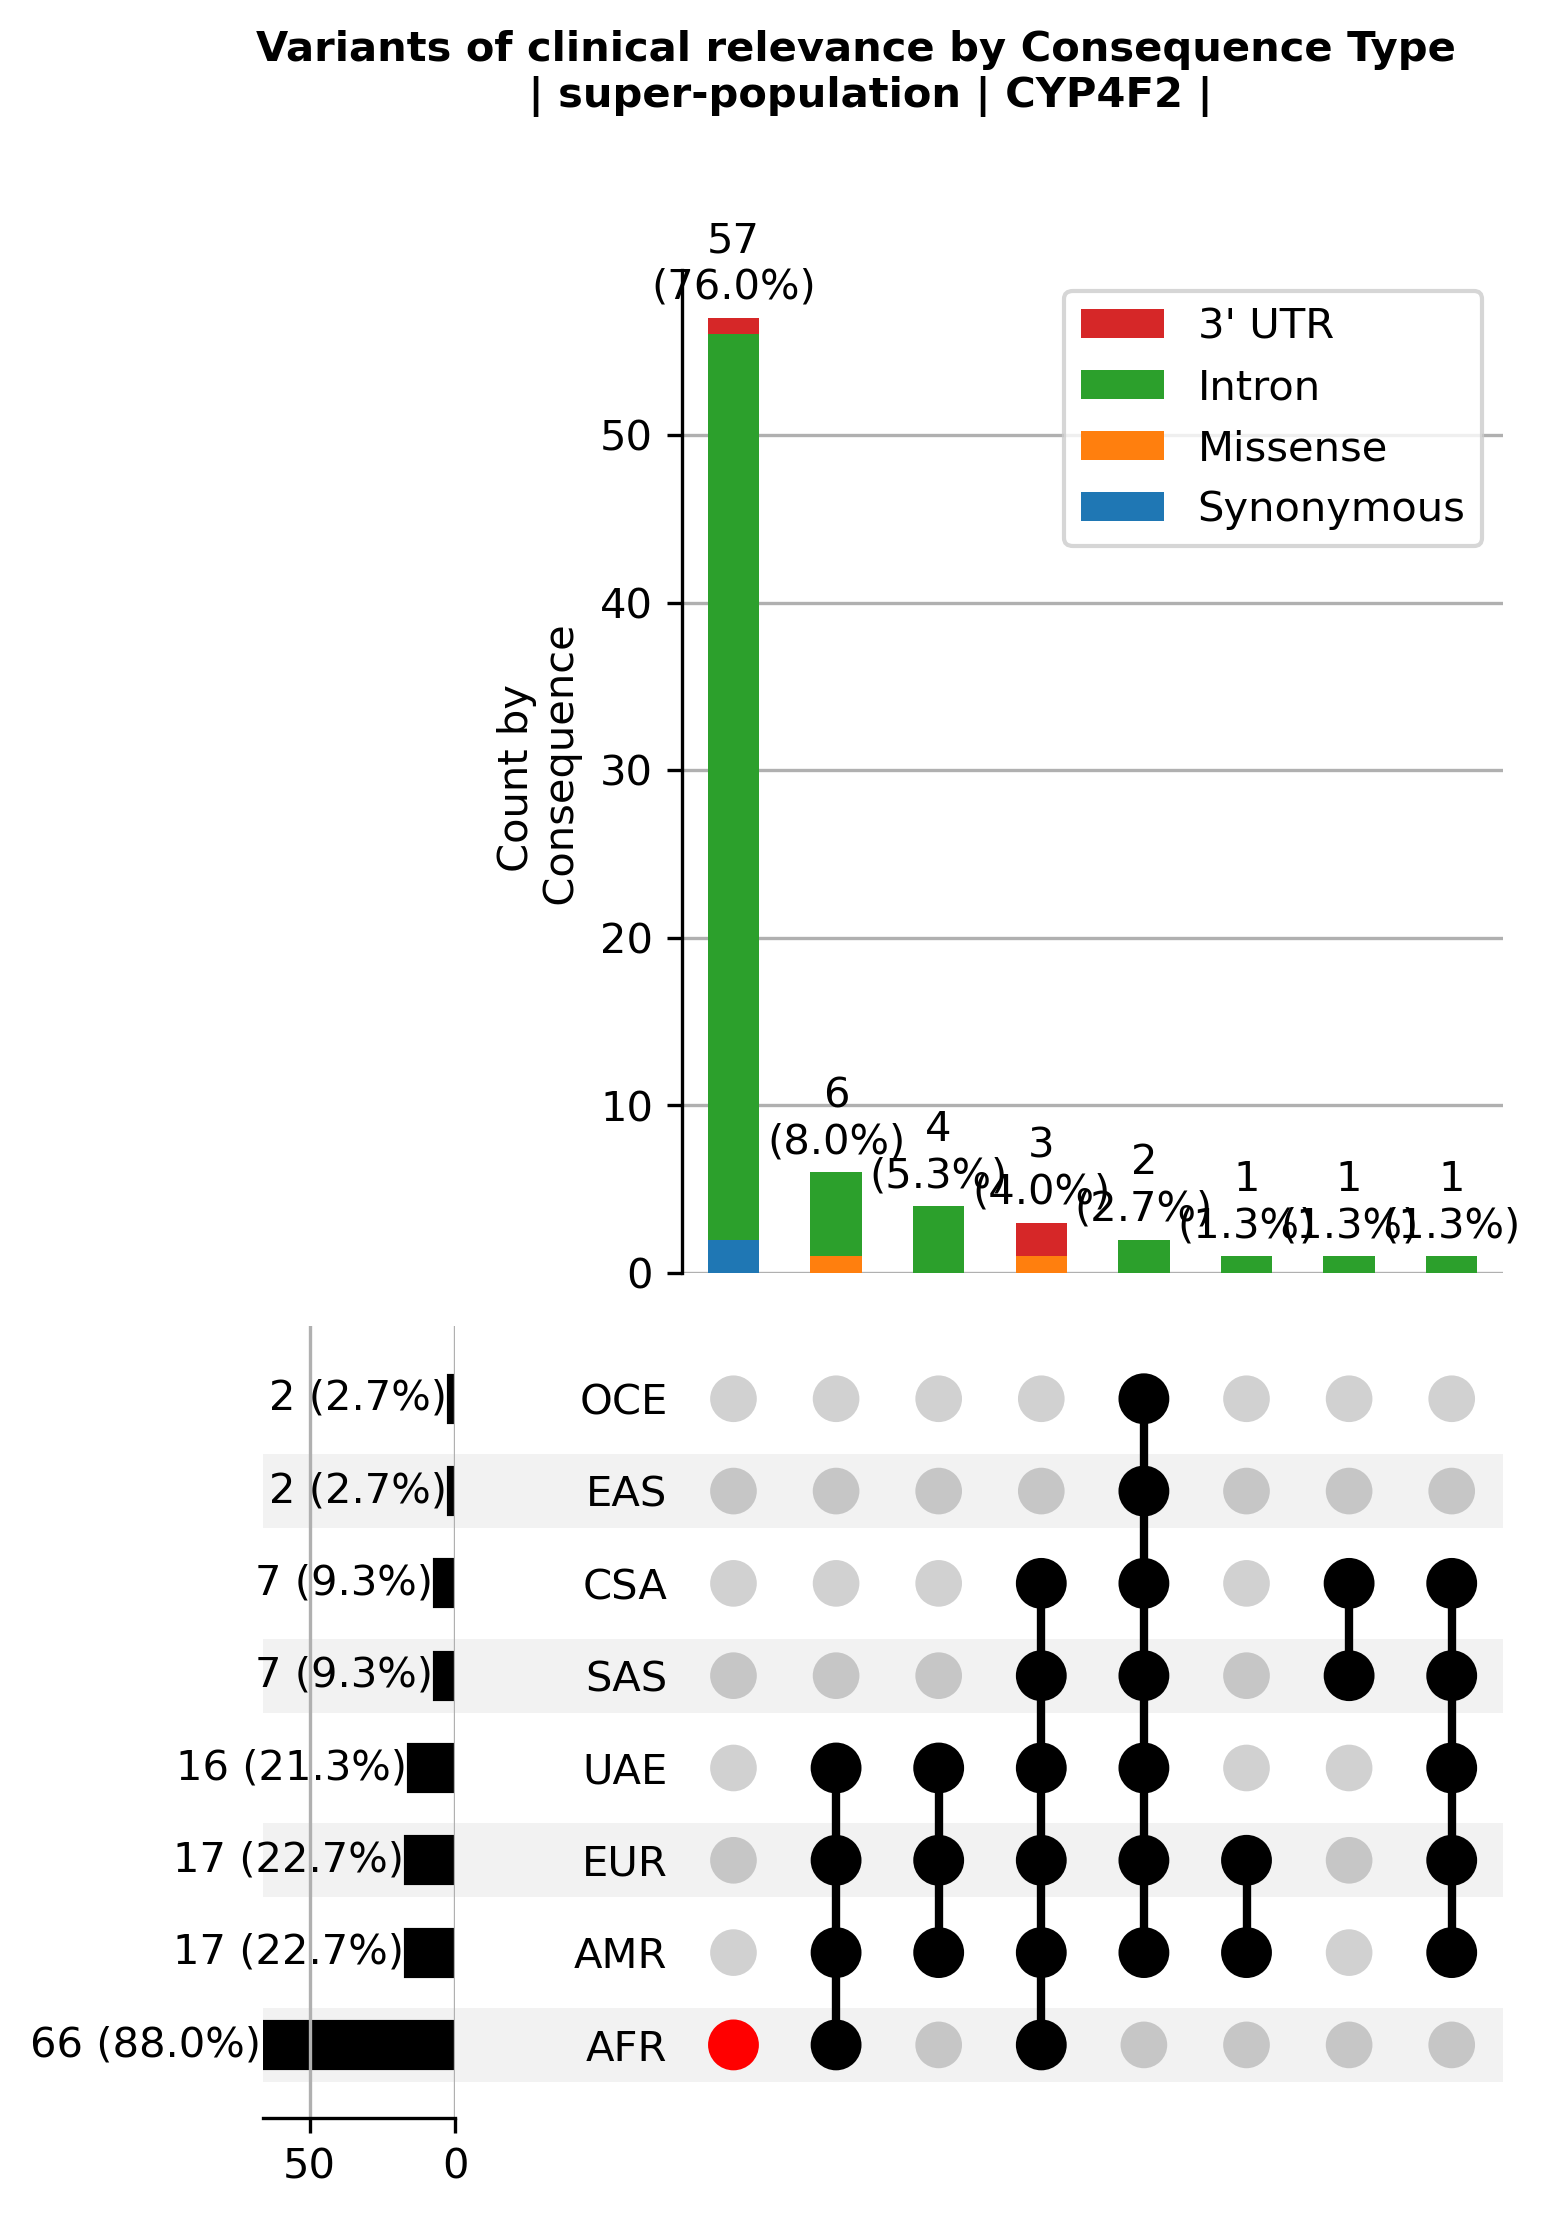

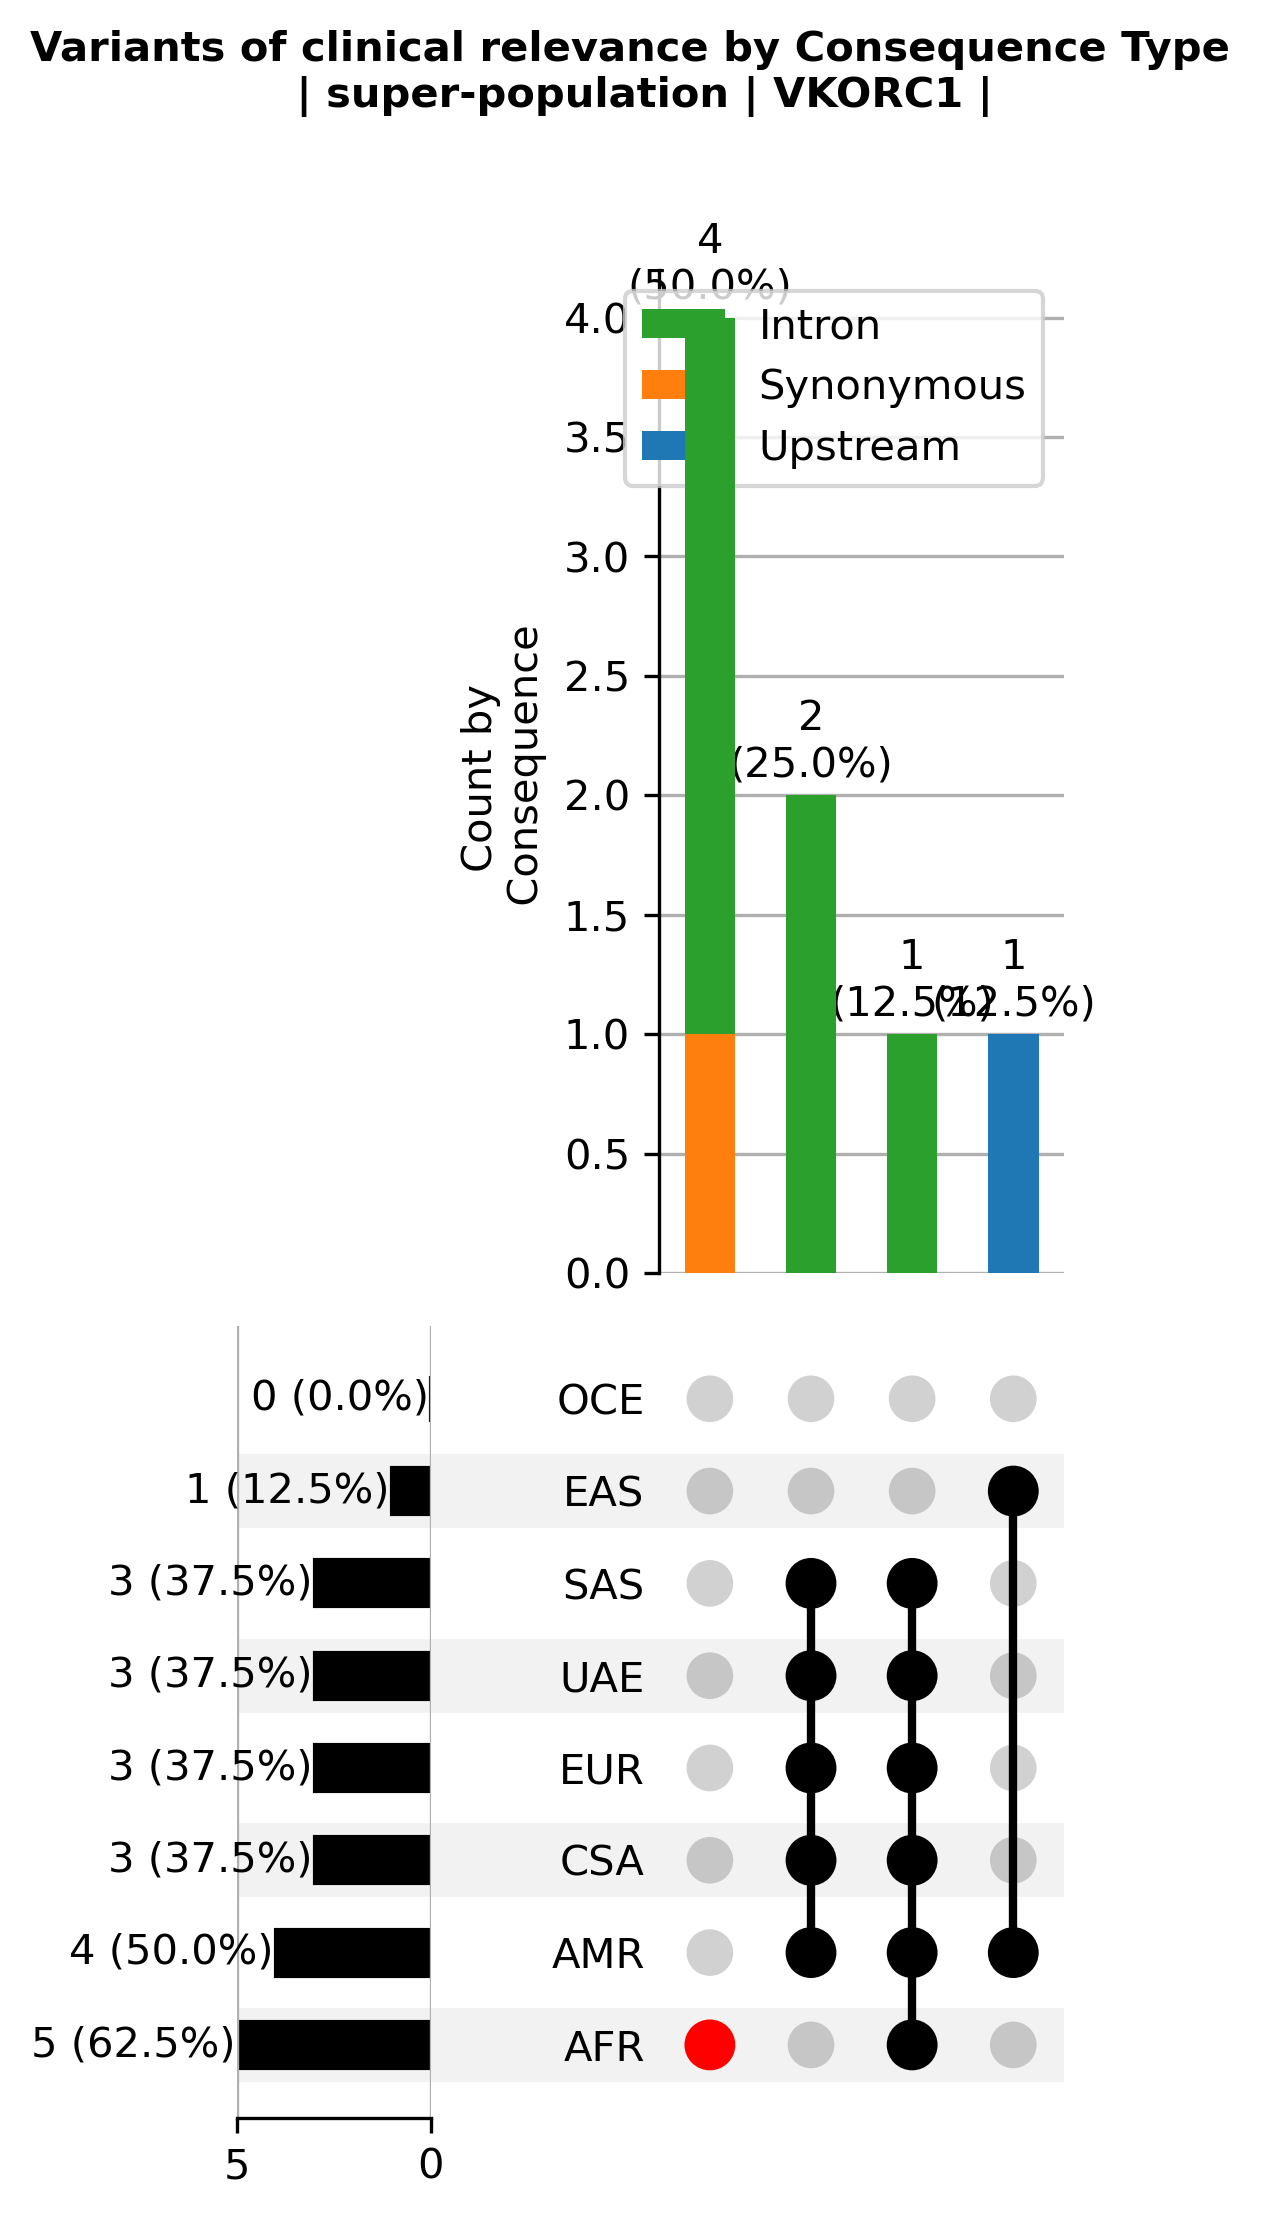

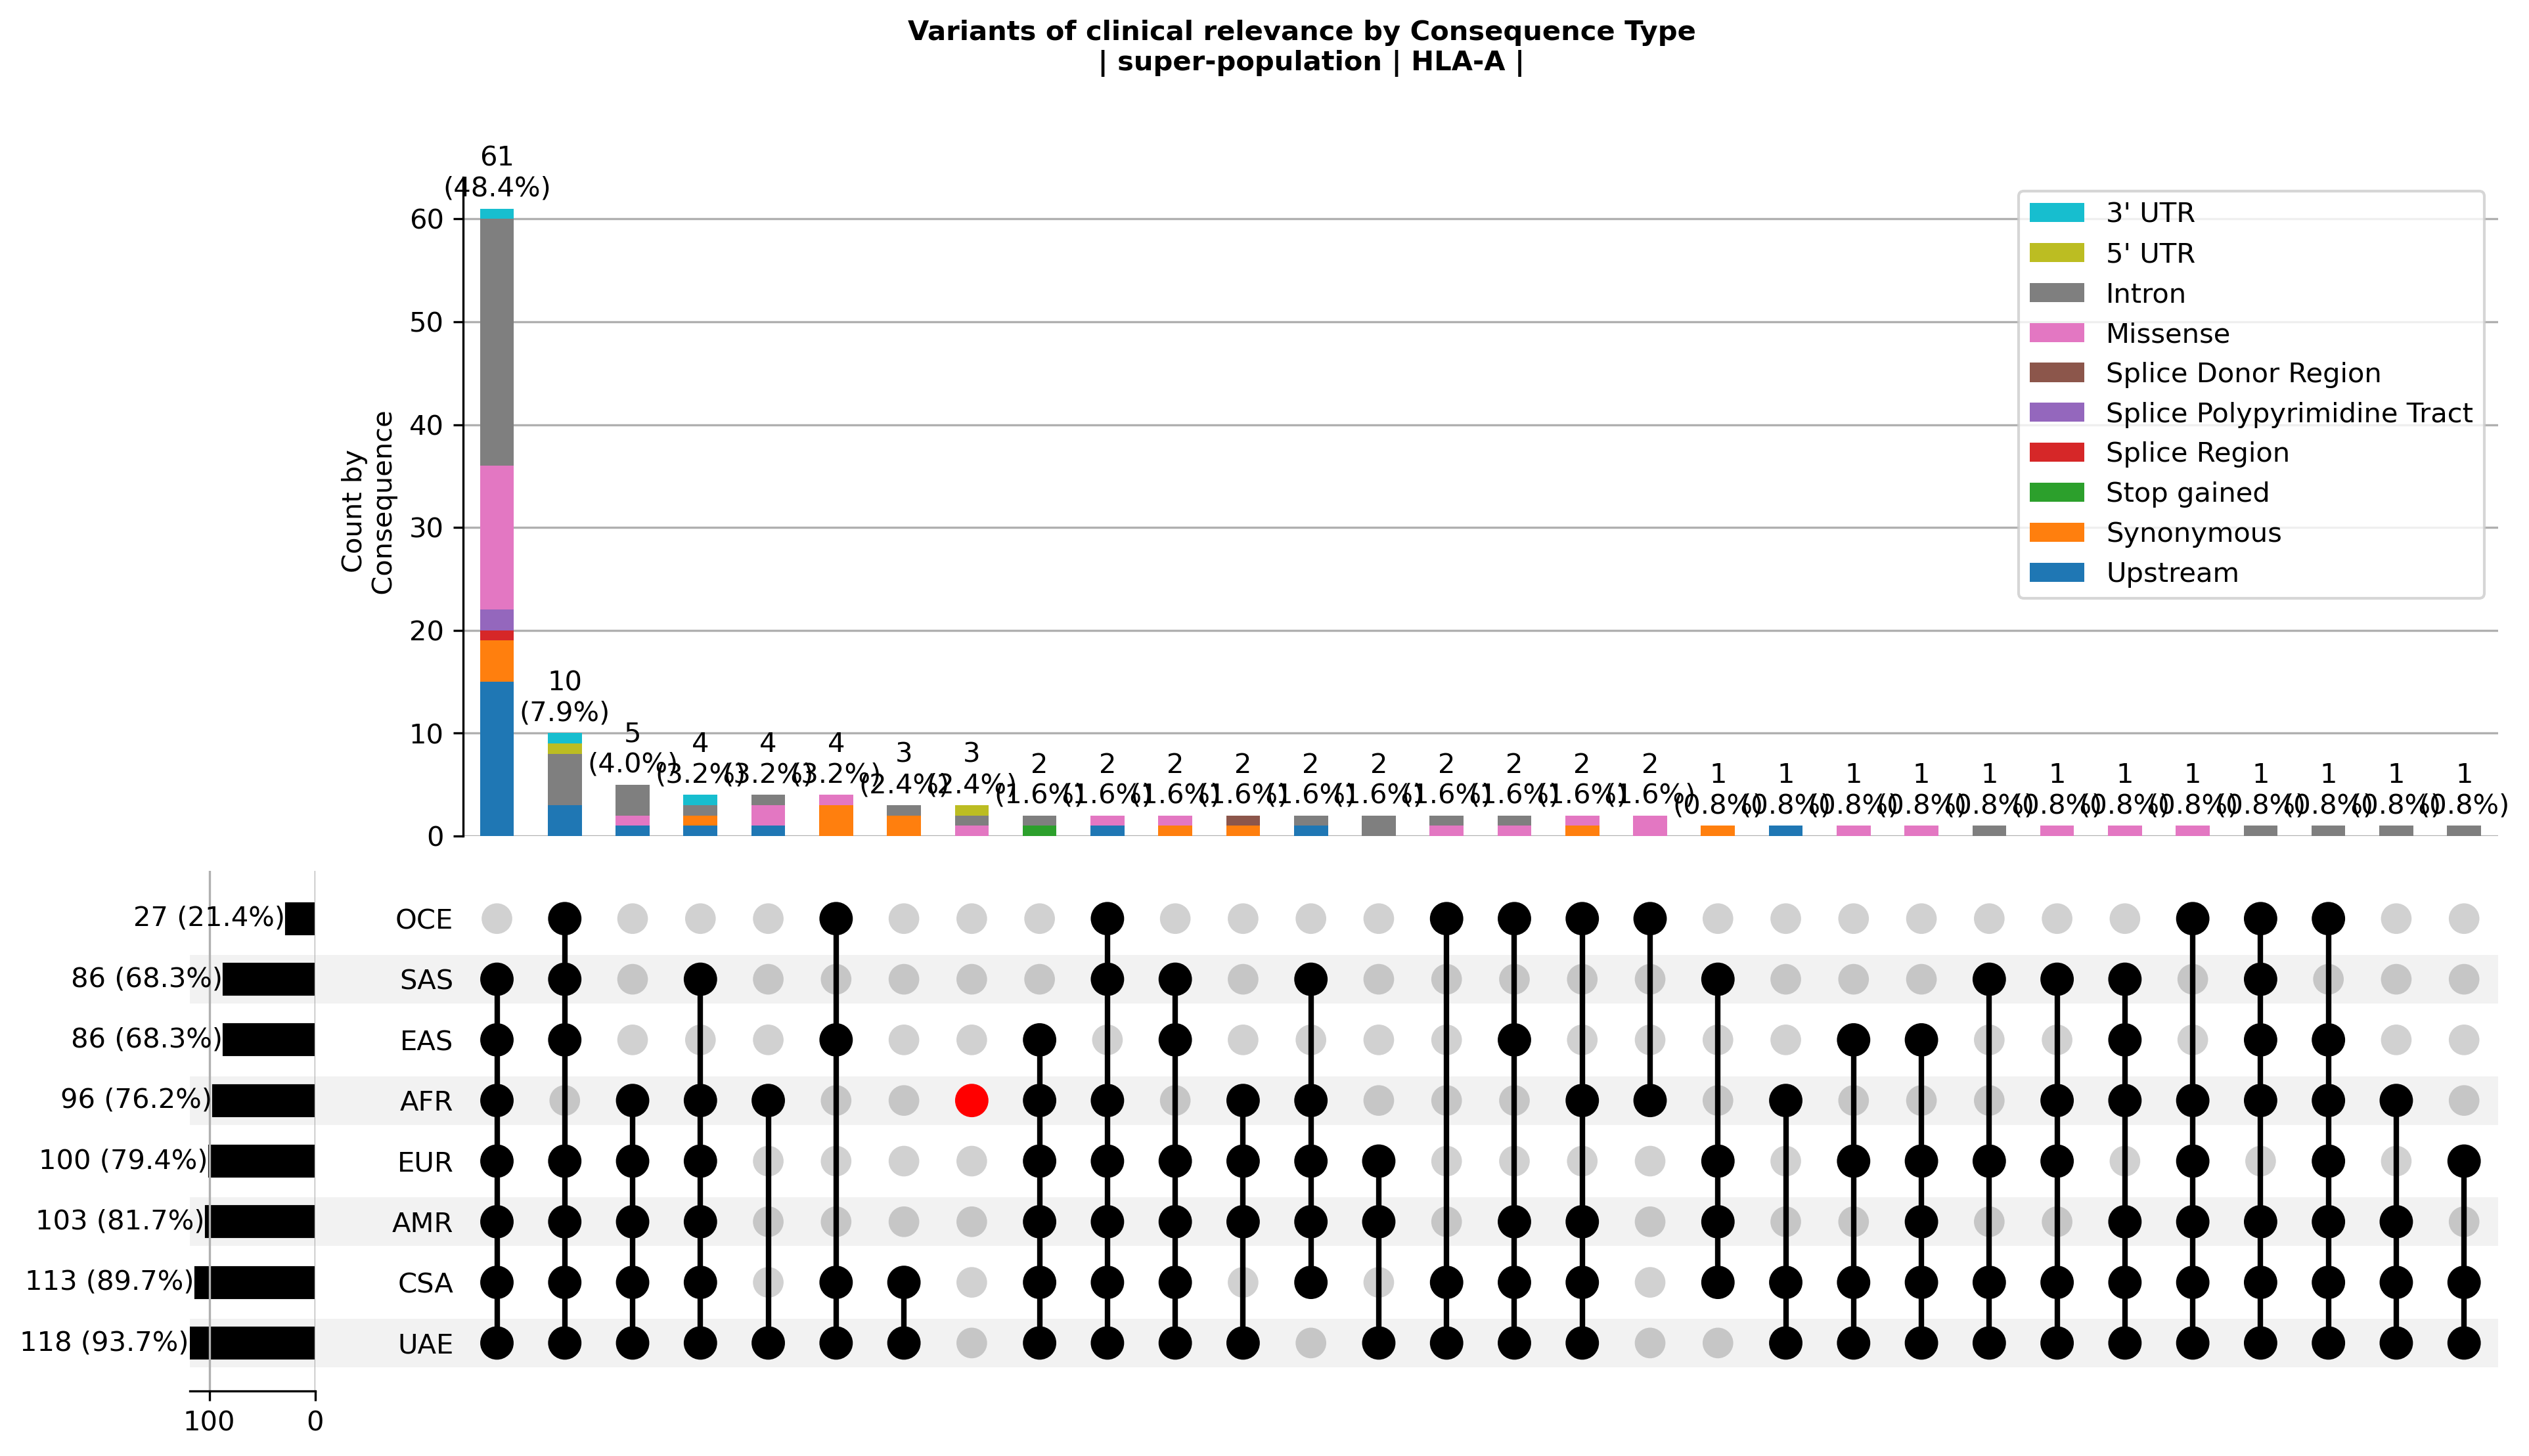

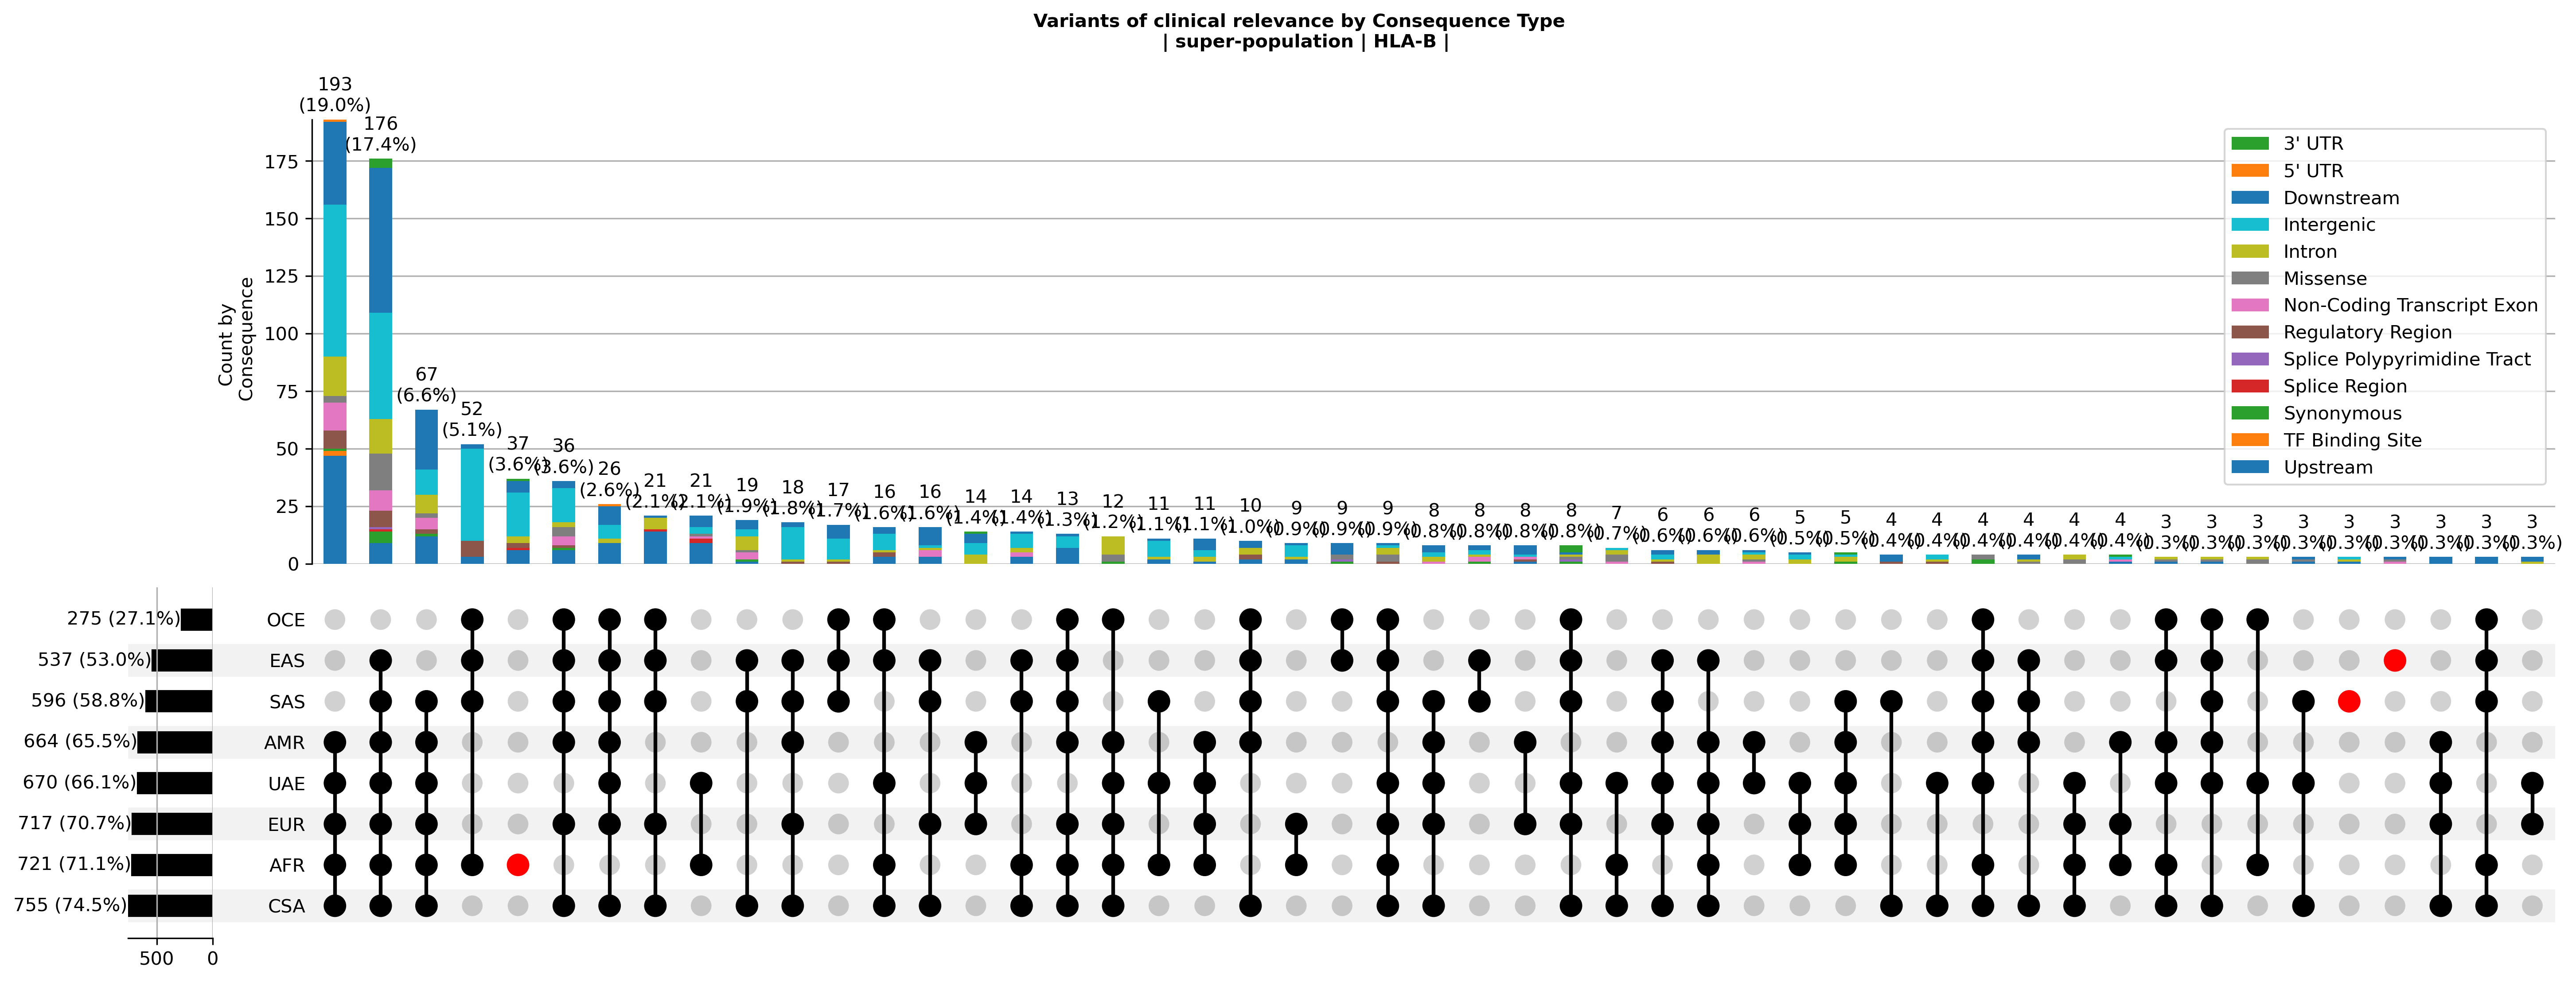

In [10]:
for gene in LOCATIONS["location_name"].unique().tolist():
    # _FIGURE = Figure(dpi=300)
    # _GRIDSPEC = UPSETPLOT[gene].make_grid(fig=_FIGURE)
    # # _FIGURE.add_gridspec(_GRIDSPEC["gs"])
    
    # _SHADING_SUBPLOT = _FIGURE.add_subplot(_GRIDSPEC["shading"])
    # UPSETPLOT[gene].plot_shading(ax=_SHADING_SUBPLOT)

    # _TOTALS_SUBPLOT = _FIGURE.add_subplot(_GRIDSPEC["totals"])
    # UPSETPLOT[gene].plot_totals(ax=_TOTALS_SUBPLOT)
            
    # _MATRIX_SUBPLOT = _FIGURE.add_subplot(_GRIDSPEC["matrix"])
    # UPSETPLOT[gene].plot_matrix(ax=_MATRIX_SUBPLOT)

    # _EXTRA1_SUBPLOT = _FIGURE.add_subplot(_GRIDSPEC["extra1"])
    # UPSETPLOT[gene]._plot_catplot(ax=_EXTRA1_SUBPLOT)
    
    # _EXTRA0_SUBPLOT = _FIGURE.add_subplot(_GRIDSPEC["extra0"])
    # _AXES = UPSETPLOT[gene].plot(fig=_FIGURE)
    # _AXES["extra0"].legend(title="Consequence Type")
            

    # UPSETPLOT[gene].plot(fig=_FIGURE)
    # _FIGURE.suptitle(
    #     f"Variants of clinical relevance by Consequence Type \n | super-population | {gene} |",
    #     fontweight="bold",
    #     fontsize="medium",
    # )
    display(UPSETPLOT[gene])
    UPSETPLOT[gene].savefig(join("Graphs", "04", f"{gene}_frequency_proportions.jpeg"))